# This is a preview of the application of DANSy to data associated with differential gene expression analysis.

The dataset being used here was downloaded from the publication Shimpi AA, Tan ML et al. Adv Healthcare Mater 2023 doi: https://doi.org/10.1002/adhm.202202224

In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from pybiomart import Dataset
import seaborn as sns
import random
from tqdm import tqdm
import scipy.stats as stats
import generateCompleteProteome
import ngramNets


In [2]:

# Creating some default parameters for future plots.
plt.rcParams['font.size'] = 5
plt.rcParams['axes.labelsize'] = 5
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['savefig.pad_inches'] = 0.01
plt.rcParams['legend.edgecolor'] = 'k'
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 3


In [3]:

# Importing the entire proteome
complete_ref,_ = generateCompleteProteome.import_proteome_files(reference_file_suffix='May12_2025.csv')

# Network drawing aesthetic parameters which will be used for consistency across network graphs.
net_draw_params = {'node_size':1, 'edgecolors':'k',
        'edge_color':'#808080', 'width':0.1, 'linewidths':0.2}

# pybiomart database for gene name conversions
dataset = Dataset(host = 'http://useast.ensembl.org', name='hsapiens_gene_ensembl',)
gene_ID_conv = dataset.query(attributes=['ensembl_gene_id','external_gene_name','external_synonym','uniprotswissprot'])


In [4]:
hasOE_dataset = pd.read_csv('DEG_data/MCF10_HAS_overexpression.csv')
hasOE_deg = ngramNets.DegDatasetNetworks(hasOE_dataset, gene_ID_conv, data_ids=['ensembl_gene_id','external_gene_name'], uniprot_ref=complete_ref, dbl_check=True)

The following parameters were ignored:['dbl_check']
Starting to fetch n-grams.
Finished getting all n-grams
Starting to generate adjacency
Finished building adjacency.
Building the reference network information.


Text(0.5, 0, '-log10(p)')

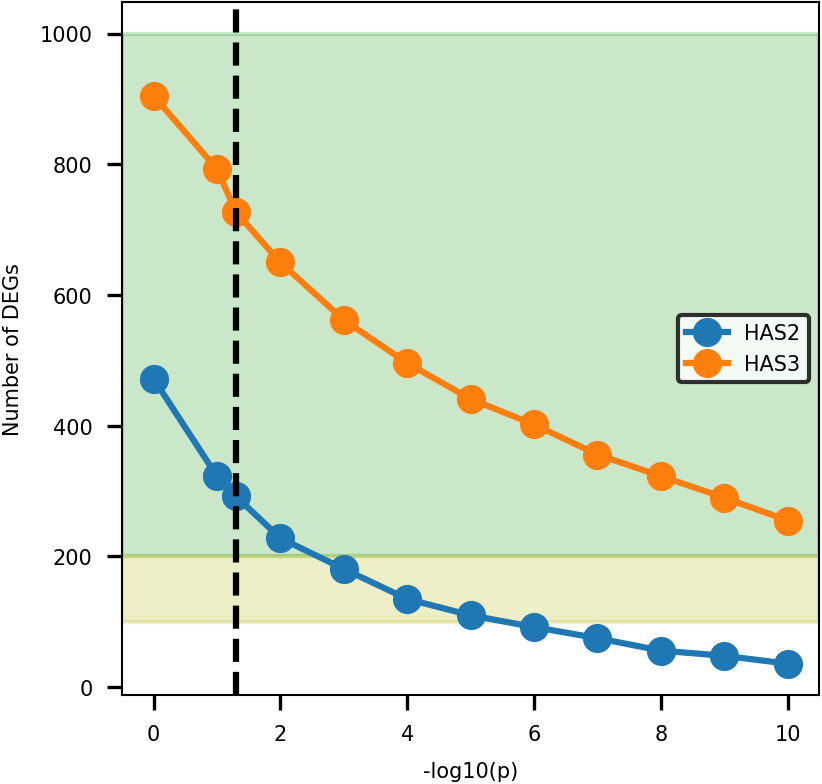

In [5]:
p_vals = np.logspace(0,-10,11)
p_vals = sorted(np.append(p_vals, 0.05),reverse=True)
conds = ['HAS2', 'HAS3']
full_degs = np.empty((2,len(p_vals)))
for j,cond in enumerate(conds):
    deg_nums = np.empty(len(p_vals))
    for i,p in enumerate(p_vals):
        hasOE_deg.calc_DEG_ngrams(data_cols=['log2FoldChange_'+cond,'padj_'+cond],alpha=p,batch_mode=True)
        num_DEGs = len(hasOE_deg.up_DEGs + hasOE_deg.down_DEGs)
        deg_nums[i] = num_DEGs
    full_degs[j] = deg_nums

x = np.tile(-np.log10(p_vals), (len(conds),1))

plt.plot(x.T,full_degs.T, marker = 'o')
plt.fill_between([-0.5,10.5], y1=200, y2 = 1000, alpha=0.25, color = 'tab:green')
plt.fill_between([-0.5,10.5], y1=100, y2 = 200, alpha=0.25, color = 'tab:olive')
plt.axvline(-np.log10(0.05), color = 'k', linestyle = '--',zorder=2)
plt.legend(conds)
plt.margins(x = 0)
plt.ylabel('Number of DEGs')
plt.xlabel('-log10(p)')

In [6]:
cond = 'HAS2'
p = 0.05
hasOE_deg.calc_DEG_ngrams(data_cols=['log2FoldChange_'+cond,'padj_'+cond],alpha=p,batch_mode=True)

In [7]:
pos = nx.spring_layout(hasOE_deg.G, seed = 882, k = 0.04)

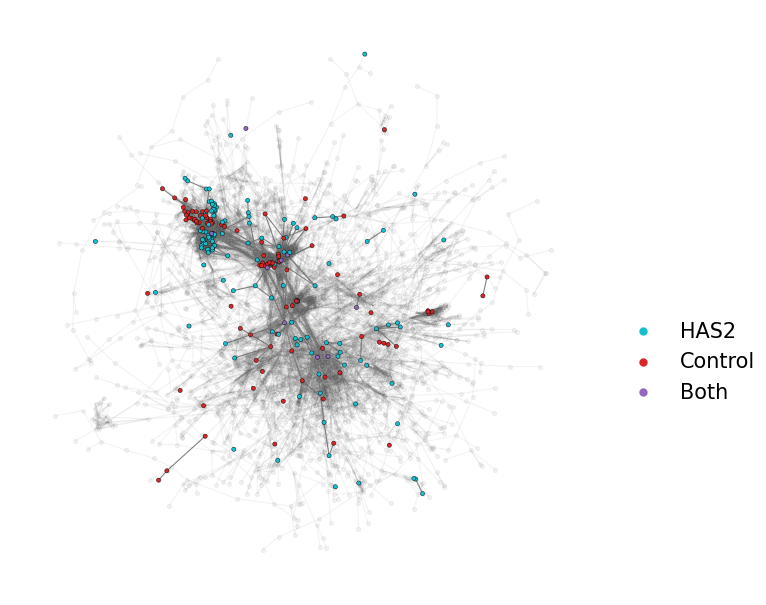

In [8]:
hasOE_deg.plot_DEG_ns(pos = pos, deg_labels=['HAS2','Control'], large_cc_mode = True)